### Going through the Hifly Pandas practice exercise

#### 1. Reading in an xlsx file

In [2]:
import pandas as pd
from IPython.display import display

In [3]:
data = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

#### 2. StockCode - Description relation, price changes for products by country

##### 2.1 relationships

In [239]:
data[["StockCode", "Description"]]. \
groupby("StockCode"). \
count(). \
reset_index(). \
rename(columns={'Description' : 'count'}). \
head()

,StockCode,count
0,10002,71
1,10080,23
2,10120,30
3,10125,94
4,10133,200


In [240]:
data[["StockCode", "Description"]]. \
groupby("Description"). \
count(). \
reset_index(). \
rename(columns={'StockCode' : 'count'}). \
head()

,Description,count
0,20713,1
1,4 PURPLE FLOCK DINNER CANDLES,41
2,50'S CHRISTMAS GIFT BAG LARGE,130
3,DOLLY GIRL BEAKER,181
4,I LOVE LONDON MINI BACKPACK,88


Relationship is at least one-to-many, possibly many-to-many

In [242]:
display(data.groupby(['StockCode']). \
agg({'Description': 'nunique'}). \
reset_index(). \
rename(columns={'Description' : 'count_unique_descriptions'}). \
sort_values(by=['count_unique_descriptions'], ascending=False). \
head())

display(data.groupby(['Description']). \
agg({'StockCode': 'nunique'}). \
reset_index(). \
rename(columns={'StockCode' : 'count_unique_stockcodes'}). \
sort_values(by=['count_unique_stockcodes'], ascending=False). \
head())

,StockCode,count_unique_descriptions
96,20713,8
1905,23084,7
794,21830,6
2825,85175,6
352,21181,5


,Description,count_unique_stockcodes
4116,check,146
122,?,47
4126,damages,43
4124,damaged,43
4142,found,25


##### 2.2 Price changes for products by country

If the standard deviation of prices by product by country is > 0, that means price changes occured at least once during the time frame

In [5]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

funcs = {
    'InvoiceDate':{
        'start_date':   'min',
        'end_date':     'max',
        'duration':     lambda x: x.max() - x.min(),
    },
    'UnitPrice':             'std'
}

price_changes = data.groupby(['StockCode', 'Country'])['InvoiceDate','UnitPrice'].agg(funcs).reset_index()
price_changes[price_changes['std'] > 0].head()

C:\Users\Krisz\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,StockCode,Country,start_date,end_date,duration,std
6,10002,United Kingdom,2010-12-01 09:45:00,2011-04-28 15:05:00,148 days 05:20:00,0.433532
7,10080,United Kingdom,2011-02-27 13:47:00,2011-11-21 17:04:00,267 days 03:17:00,0.149133
10,10125,France,2011-01-06 14:26:00,2011-11-16 11:59:00,313 days 21:33:00,0.175547
11,10125,Germany,2011-01-07 12:28:00,2011-12-09 10:13:00,335 days 21:45:00,0.222051
13,10125,United Kingdom,2010-12-01 12:23:00,2011-12-04 12:08:00,367 days 23:45:00,0.280714


#### 3. Negative amount / price filters

##### 3.1. negative amounts

In [244]:
data[data['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50000,14527.00000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65000,15311.00000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65000,17548.00000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29000,17548.00000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29000,17548.00000,United Kingdom


These by themselves are not errors, as they're canceled orders (probably sold and bought back later. However, if the Invoice suggests no cancellation, then the items are most likely errors and need to be dropped.

In [245]:
data[(data['Quantity'] < 0) & (~data['InvoiceNo'].str.startswith('C', na = False))].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.00000,nan,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.00000,nan,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.00000,nan,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.00000,nan,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.00000,nan,United Kingdom


Let's drop these

In [246]:
data.shape

(541909, 8)

In [6]:
data.drop(data[(data['Quantity'] < 0) & (~data['InvoiceNo'].str.startswith('C', na = False))].index, axis=0, inplace = True)

In [7]:
data.shape

(540573, 8)

##### 3.2. negative prices

In [249]:
data[data['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06000,nan,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06000,nan,United Kingdom


In [250]:
data.shape

(540573, 8)

In [8]:
data.drop(data[data['UnitPrice'] < 0].index, axis=0, inplace = True)

In [9]:
data.shape

(540571, 8)

#### 4. Calculations

##### 4.1 Mean, median and std of prices by countries by products

In [258]:
pd.set_option("display.precision", 2)
data.groupby(['StockCode', 'Country']).agg({'UnitPrice':['mean', 'median', 'std']}).head(10).fillna('')

UnitPrice                
                              mean  median     std
StockCode Country                                 
10002     EIRE             0.85000 0.85000        
          France           0.85000 0.85000 0.00000
          Germany          0.85000 0.85000        
          Japan            0.85000 0.85000        
          Spain            0.85000 0.85000        
          Switzerland      0.85000 0.85000        
          United Kingdom   1.12034 0.85000 0.41220
10080     United Kingdom   0.37667 0.39000 0.14913
10120     France           0.21000 0.21000        
          United Kingdom   0.21000 0.21000 0.00000

##### 4.2 z-scores per product

In [261]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
by_product = data.groupby('StockCode')['UnitPrice'].agg(['mean']).reset_index()
by_product['z_score'] = ss.fit_transform(by_product[['mean']])
by_product.head()

,StockCode,mean,z_score
0,10002,1.07153,-0.03699
1,10080,0.37667,-0.04028
2,10120,0.21000,-0.04107
3,10125,0.85968,-0.03799
4,10133,0.64905,-0.03899


Let's check the price distribution

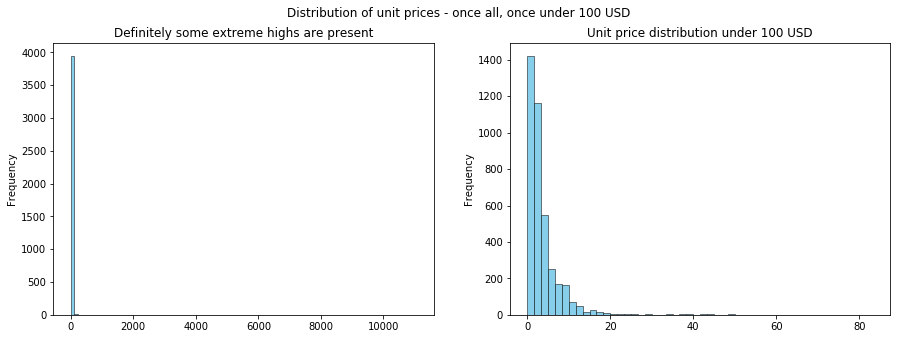

In [278]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Distribution of unit prices - once all, once under 100 USD')

by_product['mean'].plot(bins = 100,
                      kind='hist', 
                      color = 'skyblue',
                      lw = 0.5, 
                      ec = 'black',
                      title = "Definitely some extreme highs are present",
                      ax=axes[0],
                      figsize = (15,5))

by_product[by_product['mean'] < 100]['mean'].plot(bins = 50,
                              kind='hist', 
                              color = 'skyblue',
                              lw = 0.5, 
                              ec = 'black',
                              title = "Unit price distribution under 100 USD",                        
                              ax=axes[1])

plt.show()

In [280]:
data[data['UnitPrice'] > 100].count()

InvoiceNo      1036
StockCode      1036
Description    1036
Quantity       1036
InvoiceDate    1036
UnitPrice      1036
CustomerID      302
Country        1036
dtype: int64

In [281]:
# I'll keep the high values, I just wanted to see why the zscores were negative --> due to extreme highs the mean increased

##### 4.3 Average basket size

###### 4.3.1 & 4.3.2. Number of products and number of unique products

In [293]:
count_and_unique = data.groupby('StockCode').UnitPrice.agg({'UnitPrice' : ['count', 'nunique']}).reset_index()
count_and_unique.head()

C:\Users\Krisz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


StockCode UnitPrice        
                count nunique
0     10002        72       4
1     10080        24       3
2     10120        30       1
3     10125        94       6
4     10133       199       7

###### 4.3.3 Creating bins out of the results

In [304]:
bins_count = [0, 5, 10, 20, 50, count_and_unique['UnitPrice']['count'].max()]
bins_unique = [0, 5, 10, 20, 50, count_and_unique['UnitPrice']['nunique'].max()]

count_and_unique['count_binned'] = pd.cut(count_and_unique['UnitPrice']['count'], bins_count)
count_and_unique['count_nunique'] = pd.cut(count_and_unique['UnitPrice']['nunique'], bins_unique)

count_and_unique.head()

StockCode UnitPrice         count_binned count_nunique
                count nunique                           
0     10002        72       4   (50, 2312]        (0, 5]
1     10080        24       3     (20, 50]        (0, 5]
2     10120        30       1     (20, 50]        (0, 5]
3     10125        94       6   (50, 2312]       (5, 10]
4     10133       199       7   (50, 2312]       (5, 10]

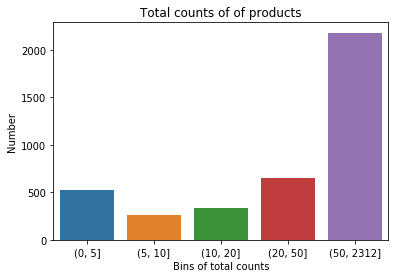

In [309]:
import seaborn as sns

sns.countplot(x = 'count_binned',
              data = count_and_unique)

plt.xlabel("Bins of total counts")
plt.ylabel("Number")
plt.title("Total counts of of products")
plt.show()

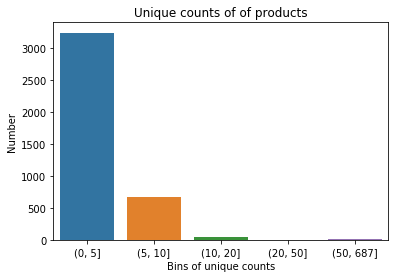

In [310]:
sns.countplot(x = 'count_nunique',
              data = count_and_unique)

plt.xlabel("Bins of unique counts")
plt.ylabel("Number")
plt.title("Unique counts of of products")
plt.show()

#### 5. Longest time between two purchases

In [359]:
data['InvoiceDate_Previous'] = data.groupby('StockCode')['InvoiceDate'].shift(1)

In [364]:
data['days_between_purchases'] = data['InvoiceDate'] - data['InvoiceDate_Previous']

In [369]:
data.sort_values('days_between_purchases', ascending = False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_Previous,days_between_purchases
507186,579168,79151B,"SILICON CUBE 25W, BLUE",10,2011-11-28 14:12:00,0.42000,17806.00000,United Kingdom,2010-12-05 12:42:00,358 days 01:30:00
478209,577078,21370,MIRRORED WALL ART FOXY,1,2011-11-17 15:17:00,12.46000,nan,United Kingdom,2010-12-01 12:31:00,351 days 02:46:00
504683,578977,90151,SILVER/NATURAL SHELL NECKLACE,2,2011-11-27 15:18:00,8.50000,17231.00000,United Kingdom,2010-12-13 14:16:00,349 days 01:02:00
504677,578977,90082D,DIAMANTE BOW BROOCH BLACK COLOUR,1,2011-11-27 15:18:00,6.35000,17231.00000,United Kingdom,2010-12-17 17:17:00,344 days 22:01:00
436484,574149,90176B,DIAMANTE NECKLACE BLACK,2,2011-11-03 11:29:00,7.50000,13709.00000,United Kingdom,2010-12-20 10:14:00,318 days 01:15:00


Longest time without a purchase was for product 79151B, with 358 days between two purchases

#### 6. Creating needed dataframe

Idea:
<img src="6.png">

In [378]:
data.drop(['InvoiceDate_Previous', 'days_between_purchases'], axis = 1, inplace = True)

In [10]:
data_commas = data.groupby(['InvoiceNo', 'InvoiceDate']). \
                    agg({'Description' : lambda x: ', '.join(set(x.astype(str))), 
                         'Country' :     lambda x: ', '.join(set(x.astype(str))), 
                         'CustomerID' :  lambda x: ', '.join(set(x.astype(str)))}). \
                    reset_index(). \
                    rename(columns={'Description' : 'Products'})

In [11]:
data_commas.head()

,InvoiceNo,InvoiceDate,Products,Country,CustomerID
0,536365,2010-12-01 08:26:00,"GLASS STAR FROSTED T-LIGHT HOLDER, WHITE METAL...",United Kingdom,17850.0
1,536366,2010-12-01 08:28:00,"HAND WARMER UNION JACK, HAND WARMER RED POLKA DOT",United Kingdom,17850.0
2,536367,2010-12-01 08:34:00,"POPPY'S PLAYHOUSE KITCHEN, BOX OF VINTAGE JIGS...",United Kingdom,13047.0
3,536368,2010-12-01 08:34:00,"BLUE COAT RACK PARIS FASHION, JAM MAKING SET W...",United Kingdom,13047.0
4,536369,2010-12-01 08:35:00,BATH BUILDING BLOCK WORD,United Kingdom,13047.0


In [12]:
# ...s don't cut off the values, they just indicate that there're more strings (products) in the given cell
data_commas['Products'][0].lower().split(",")

['glass star frosted t-light holder',
 ' white metal lantern',
 ' set 7 babushka nesting boxes',
 ' knitted union flag hot water bottle',
 ' white hanging heart t-light holder',
 ' cream cupid hearts coat hanger',
 ' red woolly hottie white heart.']

In [13]:
# we can even count the number of (unique) products corresponding to an invoice number and an invoice date
len(data_commas['Products'][0].split(","))

7

#### 7. New column with ISO 3166-2 Alpha 2 codes for countries

In [14]:
iso = pd.read_csv("https://pkgstore.datahub.io/core/country-list/data_csv/data/d7c9d7cfb42cb69f4422dec222dbbaa8/data_csv.csv")

In [15]:
unique_countries = pd.DataFrame(data['Country'].unique(), columns = ["Name"])

In [16]:
country_code_joined = unique_countries.merge(iso, left_on='Name', right_on='Name', how = 'left')
country_code_joined.head()

,Name,Code
0,United Kingdom,GB
1,France,FR
2,Australia,AU
3,Netherlands,NL
4,Germany,DE


Let's find those who couldn't be joined

In [17]:
country_code_joined[country_code_joined.isnull().T.any().T]

,Name,Code
6,EIRE,NaN
16,Channel Islands,NaN
32,Unspecified,NaN
34,USA,NaN
35,European Community,NaN
37,RSA,NaN


In [18]:
country_code_joined.xs(6)['Code'] = "IRL"
country_code_joined.xs(16)['Code'] = "GB-CHA"
country_code_joined.xs(32)['Code'] = "UNKNOWN"
country_code_joined.xs(34)['Code'] = "USA"
country_code_joined.xs(35)['Code'] = "EU"
country_code_joined.xs(37)['Code'] = "RSA"

In [19]:
# no more NaNs
country_code_joined[country_code_joined.isnull().T.any().T]

,Name,Code


In [20]:
display(data.head())
display(country_code_joined.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


,Name,Code
0,United Kingdom,GB
1,France,FR
2,Australia,AU
3,Netherlands,NL
4,Germany,DE


In [21]:
data = data.merge(country_code_joined, left_on='Country', right_on='Name', how = 'left')
del data['Name']
display(data.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Name,Code
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,United Kingdom,GB
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom,GB
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,United Kingdom,GB
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom,GB
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom,GB


#### 8. MIssing values

##### CustomerID missing: impute with last from respective country

In [22]:
data[data['CustomerID'].isnull()] # 133k missing

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Name,Code
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,United Kingdom,GB
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,United Kingdom,GB
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,United Kingdom,GB
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,United Kingdom,GB
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,United Kingdom,GB
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,United Kingdom,GB
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,United Kingdom,GB
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom,United Kingdom,GB
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom,United Kingdom,GB
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom,United Kingdom,GB


In [23]:
data["CustomerID"] = data.groupby(['Country'])['CustomerID'].fillna(method='ffill') # bahrain still has 2
data["CustomerID"] = data.groupby(['Country'])['CustomerID'].fillna(method='bfill') # only Hong Kong remains missing, but all is missing

data[data['CustomerID'].isnull()] # 288 missing remain from 133k (only HK)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Name,Code
69511,541975,22620,4 TRADITIONAL SPINNING TOPS,60,2011-01-24 14:24:00,1.25,NaN,Hong Kong,Hong Kong,HK
69512,541975,85183B,CHARLIE & LOLA WASTEPAPER BIN FLORA,6,2011-01-24 14:24:00,3.75,NaN,Hong Kong,Hong Kong,HK
69513,541975,85183A,CHARLIE & LOLA WASTEPAPER BIN BLUE,6,2011-01-24 14:24:00,3.75,NaN,Hong Kong,Hong Kong,HK
69514,541975,16236,KITTY PENCIL ERASERS,28,2011-01-24 14:24:00,0.21,NaN,Hong Kong,Hong Kong,HK
69515,541975,21058,PARTY INVITES WOODLAND,12,2011-01-24 14:24:00,0.85,NaN,Hong Kong,Hong Kong,HK
69516,541975,21967,PACK OF 12 SKULL TISSUES,24,2011-01-24 14:24:00,0.29,NaN,Hong Kong,Hong Kong,HK
69517,541975,21981,PACK OF 12 WOODLAND TISSUES,24,2011-01-24 14:24:00,0.29,NaN,Hong Kong,Hong Kong,HK
69518,541975,22553,PLASTERS IN TIN SKULLS,36,2011-01-24 14:24:00,1.65,NaN,Hong Kong,Hong Kong,HK
69519,541975,22556,PLASTERS IN TIN CIRCUS PARADE,36,2011-01-24 14:24:00,1.65,NaN,Hong Kong,Hong Kong,HK
69520,541975,22554,PLASTERS IN TIN WOODLAND ANIMALS,36,2011-01-24 14:24:00,1.65,NaN,Hong Kong,Hong Kong,HK


#### 9. Random selection, saving to list

In [33]:
random = data['StockCode'].sample(n = 100, random_state = 20200305)
random = random.tolist()

In [50]:
print("elements in list:", len(random), "unique elements:", len(set(random)))

elements in list: 100 unique elements: 93


In [53]:
selected_by_random_stockcodes = data[data['StockCode'].isin(random)]
selected_by_random_stockcodes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Name,Code
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,United Kingdom,GB
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,United Kingdom,GB
15,536367,22623,BOX OF VINTAGE JIGSAW BLOCKS,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,United Kingdom,GB
18,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom,United Kingdom,GB
20,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom,United Kingdom,GB


#### 10. df with annual growth rates by country by product

In [76]:
data['InvoiceDate'].dtypes

dtype('<M8[ns]')

In [152]:
data['InvoiceYear'] = pd.DatetimeIndex(data['InvoiceDate']).year

In [90]:
data[['InvoiceYear', 'InvoiceNo']].groupby('InvoiceYear').count()

,InvoiceNo
InvoiceYear,
2010,42411
2011,498160


In [129]:
data['UnitPricePrevYear'] = data.groupby(['InvoiceYear','Country','StockCode'])['UnitPrice'].shift(1)
data['InflRateByProdByCountry'] = (data['UnitPrice'] - data['UnitPricePrevYear']) / data['UnitPricePrevYear']
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Code,InvoiceYear,UnitPricePrevYear,InflRateByProdByCountry
540566,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,FR,2011,0.85,0.0
540567,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,FR,2011,2.10,0.0
540568,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,FR,2011,4.15,0.0
540569,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,FR,2011,4.15,0.0
540570,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,FR,2011,4.95,0.0


In [138]:
data_infl = data.copy()

In [139]:
data_infl.drop(['InvoiceNo', 'Quantity', 'InvoiceDate', 'CustomerID', 'Code'], axis = 1, inplace = True)

In [140]:
data_infl = data_infl[data_infl['UnitPricePrevYear'] > 0] # change is not calculateable if t0 value is 0

In [142]:
data_infl.sort_values(by=['InflRateByProdByCountry'], ascending=False).head()

,StockCode,Description,UnitPrice,Country,InvoiceYear,UnitPricePrevYear,InflRateByProdByCountry
387659,BANK CHARGES,Bank Charges,472.77,United Kingdom,2011,0.001,472769.000000
172828,M,Manual,6930.00,United Kingdom,2011,0.290,23895.551724
14971,AMAZONFEE,AMAZON FEE,13541.33,United Kingdom,2010,1.000,13540.330000
267232,M,Manual,4287.63,United Kingdom,2011,0.850,5043.270588
322937,M,Manual,852.80,United Kingdom,2011,0.190,4487.421053


If Bank charges, Amazon fees, manuals, postage fees, discounts, dotcom postages should be filtered out, then the products with the largest price increase are:

In [151]:
data_infl[~data_infl["StockCode"].isin(["BANK CHARGES", 
                                        "M", 
                                        "AMAZONFEE", 
                                        "POST", 
                                        "D", 
                                        "DOT"])].sort_values(by=['InflRateByProdByCountry'], ascending=False).head()

,StockCode,Description,UnitPrice,Country,InvoiceYear,UnitPricePrevYear,InflRateByProdByCountry
246016,17003,BROCADE RING PURSE,57.60,United Kingdom,2011,0.29,197.620690
234362,17003,BROCADE RING PURSE,57.60,United Kingdom,2011,0.29,197.620690
259037,17003,BROCADE RING PURSE,57.60,United Kingdom,2011,0.29,197.620690
221973,22502,PICNIC BASKET WICKER 60 PIECES,649.50,United Kingdom,2011,4.95,130.212121
4361,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2.55,United Kingdom,2010,0.03,84.000000


#### 11. weekly income growth

In [156]:
data.drop(["UnitPricePrevYear", "InflRateByProdByCountry"], axis = 1, inplace = True)

In [159]:
# income: unit price * quantity --> sales
data["sales"] = data['UnitPrice'] * data['Quantity']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Code,InvoiceYear,sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,GB,2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,GB,2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34


In [166]:
data['WeekNumber'] = pd.DatetimeIndex(data['InvoiceDate']).week
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Code,InvoiceYear,sales,WeekNumber
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,GB,2010,15.30,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,GB,2010,22.00,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,GB,2010,20.34,48


In [167]:
weekly_growth_by_country = data.copy()

In [172]:
weekly_growth_by_country = weekly_growth_by_country.groupby(['Country', 'InvoiceYear', 'WeekNumber'])['sales'].sum().reset_index()
weekly_growth_by_country.head()

,Country,InvoiceYear,WeekNumber,sales
0,Australia,2010,48,358.25
1,Australia,2010,49,258.90
2,Australia,2010,50,387.95
3,Australia,2011,1,7154.38
4,Australia,2011,2,721.10


In [174]:
weekly_growth_by_country['sales_prev_week'] = weekly_growth_by_country['sales'].shift(1)
weekly_growth_by_country['WoW_growth'] = (weekly_growth_by_country['sales'] - weekly_growth_by_country['sales_prev_week'] ) / weekly_growth_by_country['sales_prev_week'] 
weekly_growth_by_country.head()

,Country,InvoiceYear,WeekNumber,sales,sales_prev_week,WoW_growth
0,Australia,2010,48,358.25,NaN,NaN
1,Australia,2010,49,258.90,358.25,-0.277320
2,Australia,2010,50,387.95,258.90,0.498455
3,Australia,2011,1,7154.38,387.95,17.441500
4,Australia,2011,2,721.10,7154.38,-0.899209


#### 12. cumulative (moving) aggregation / sliding window

#### recency: time between actual and last week when there was a purchase

In [176]:
data.drop(["InvoiceNo", "StockCode", "Description", "Country", "Code", "InvoiceYear", "UnitPrice"], axis = 1, inplace = True)
data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,sales,WeekNumber
0,6,2010-12-01 08:26:00,2.55,17850.0,15.30,48
1,6,2010-12-01 08:26:00,3.39,17850.0,20.34,48
2,8,2010-12-01 08:26:00,2.75,17850.0,22.00,48
3,6,2010-12-01 08:26:00,3.39,17850.0,20.34,48
4,6,2010-12-01 08:26:00,3.39,17850.0,20.34,48


In [217]:
data['Year'] = pd.DatetimeIndex(data['InvoiceDate']).year
data['InvoiceDatePrev'] = data['InvoiceDate'].shift(1)
data['TimeBetweenPurchases'] = data['InvoiceDate'] - data['InvoiceDatePrev']
data.head()

,InvoiceDate,CustomerID,sales,WeekNumber,Year,InvoiceDatePrev,TimeBetweenPurchases
0,2010-12-01 08:26:00,17850.0,15.30,48,2010,NaT,NaT
1,2010-12-01 08:26:00,17850.0,20.34,48,2010,2010-12-01 08:26:00,0 days
2,2010-12-01 08:26:00,17850.0,22.00,48,2010,2010-12-01 08:26:00,0 days
3,2010-12-01 08:26:00,17850.0,20.34,48,2010,2010-12-01 08:26:00,0 days
4,2010-12-01 08:26:00,17850.0,20.34,48,2010,2010-12-01 08:26:00,0 days


In [260]:
last = (
data. \
groupby(["CustomerID", "Year", "WeekNumber"]). \
agg({'sales' : ['sum', 'count'], 
     'TimeBetweenPurchases' : 'last'})). \
reset_index()
    
last.head()

CustomerID  Year WeekNumber   sales       TimeBetweenPurchases
                                  sum count                 last
0    12346.0  2011          3    0.00     2             00:02:00
1    12347.0  2010         49  711.79    31             00:00:00
2    12347.0  2011          4  475.39    29             00:00:00
3    12347.0  2011         14  636.25    24             00:00:00
4    12347.0  2011         23  382.52    18             00:00:00